資料參考：  
https://medium.com/@permoonzz/kaggle-house-prices-advanced-regression-techniques-python-ensemble-learning%E5%AF%A6%E5%81%9A-99f757f4d326

In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import math
import sklearn.model_selection as ms
import sklearn.metrics as sklm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
%matplotlib inline

In [3]:
train = pd.read_csv('HousePrice/train.csv')
test = pd.read_csv('HousePrice/test.csv')
submit = pd.read_csv('HousePrice/sample_submission.csv')

In [4]:
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## 先看懂資料
資料大致可分為：

    ● 1.建物面積：1stFlrSF(一樓面積)、GrLivArea(一樓以上總生活空間)、TotalBsmtSF(地下室總面積)等。  
    ● 2.裝置數量：FullBath、Kitchen、Bedroom數量。
    ● 3.量表型類別特徵：ExterCond(外部狀態)、ExterQual(外觀材質)、GarageQual(車庫品質)等，這類型特徵的值為
      Excellent/Good/Averege/Fair/Poor等具有順序特性。
    ● 4.一般類別特徵：Neighborhood(所在區域)、HouseStyle(房屋型式)等。
    ● 5.日期相關特徵：YrSold(售出年度)、MoSold(售出月份)、GarageYrBlt(車庫建造年度)等。

## 探索性資料分析 (Exploratory Data Analysis, EDA)
用表格或圖像化的方式，對資料樣貌進行更進一步的了解

In [5]:
# 合併 train 跟 test 資料
data = pd.concat((train, test), sort=False).reset_index(drop=True)

In [12]:
# 先處理數值類型的資料
num_data = data.select_dtypes(['int64','float64'])
describe_num = data.describe().transpose()
describe_num

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


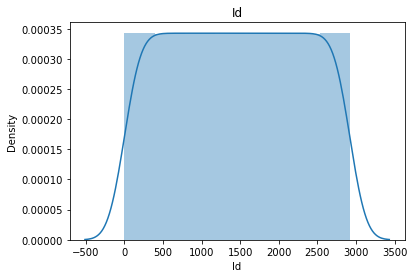

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


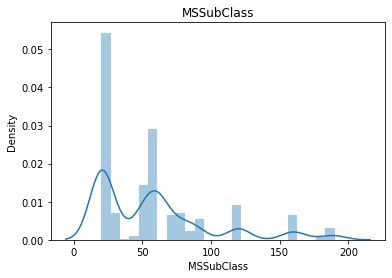

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


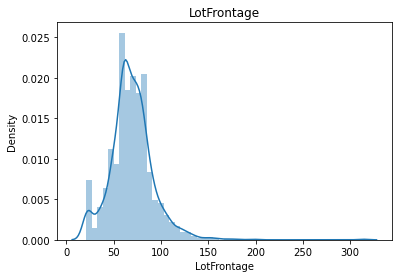

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


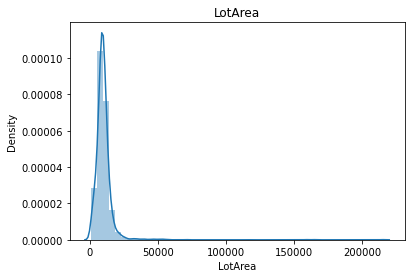

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


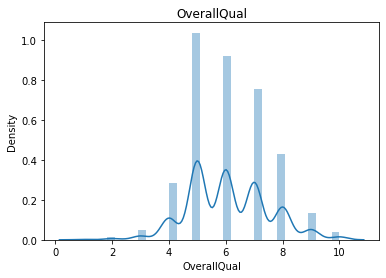

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


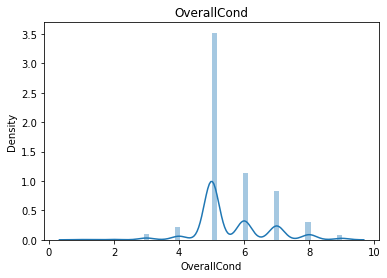

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


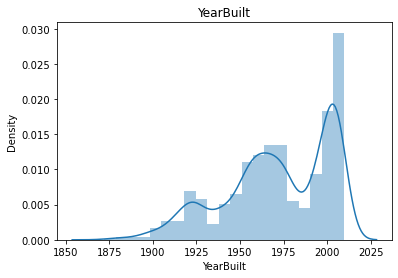

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


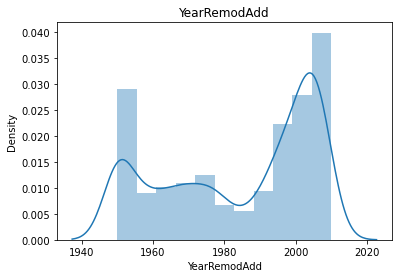

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


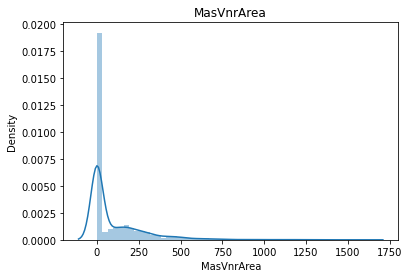

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


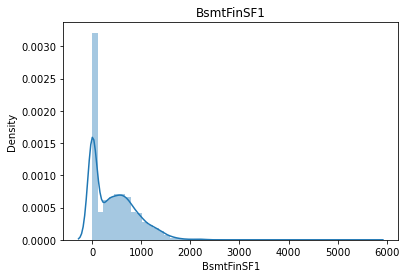

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


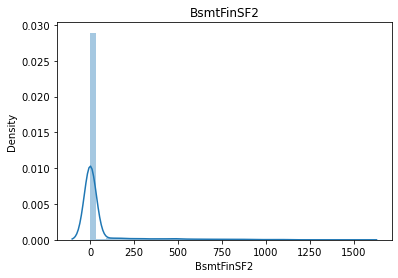

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


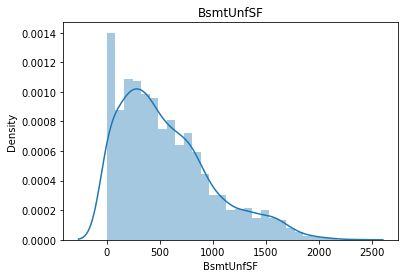

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


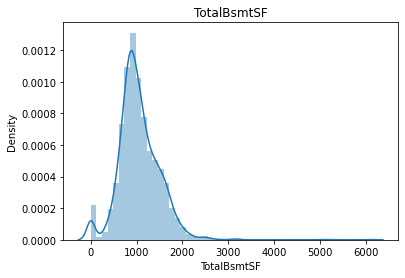

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


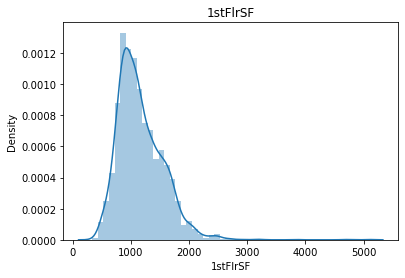

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


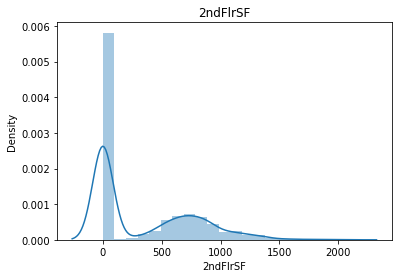

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


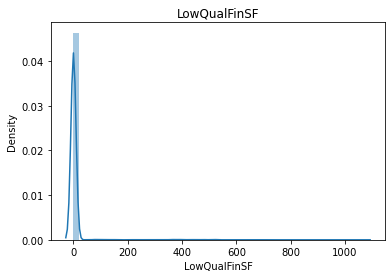

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


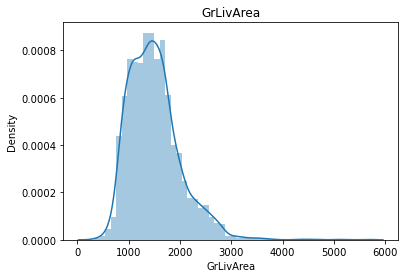

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


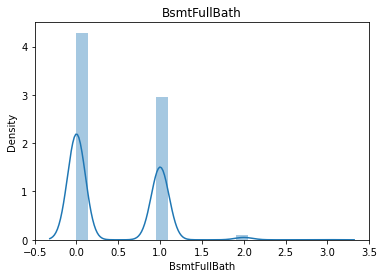

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


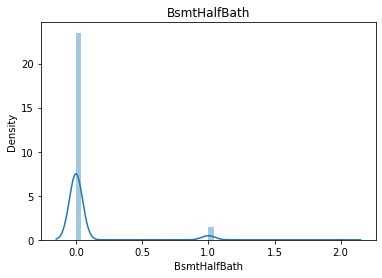

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


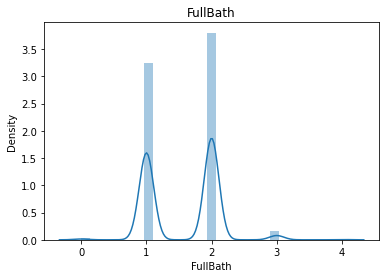

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


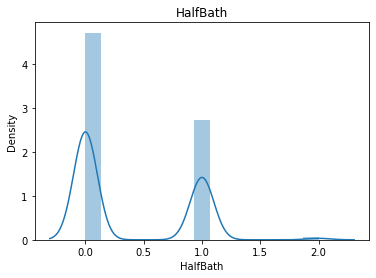

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


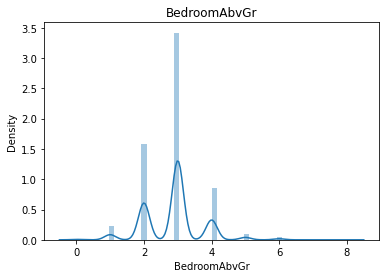

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


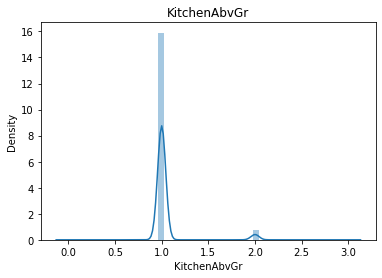

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


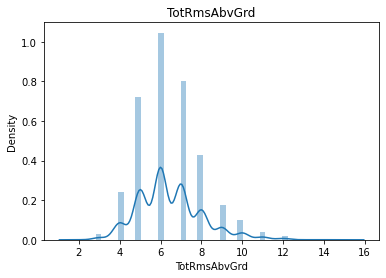

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


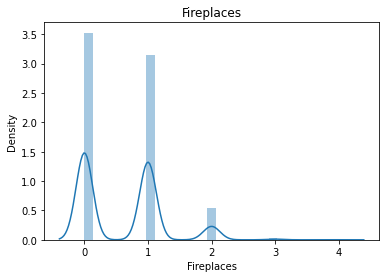

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


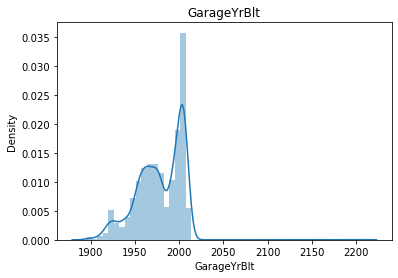

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


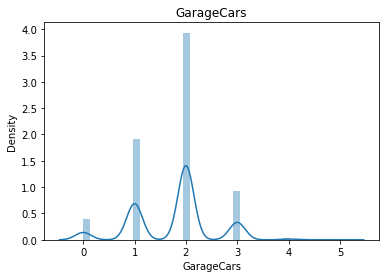

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


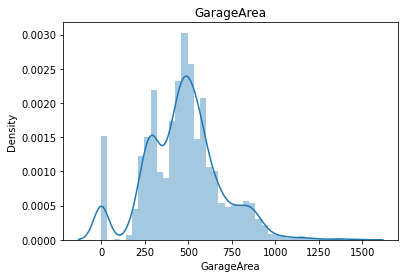

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


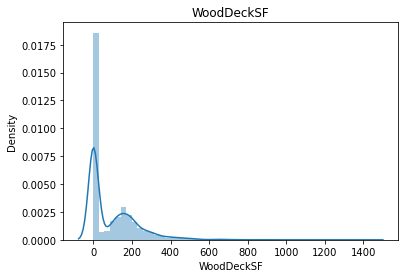

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


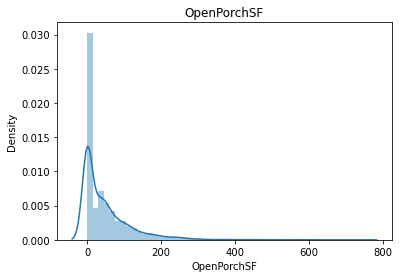

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


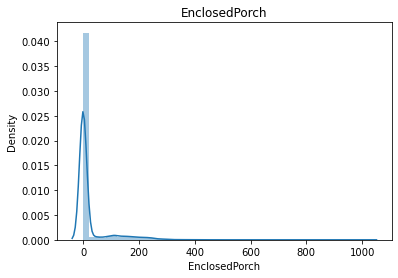

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


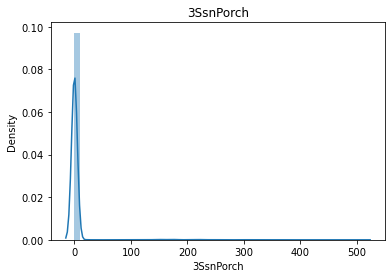

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


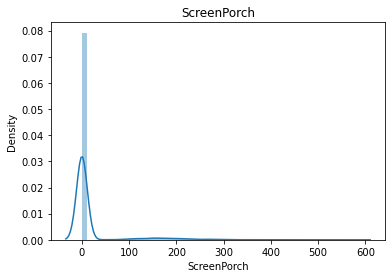

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


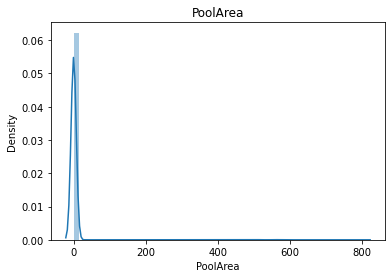

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


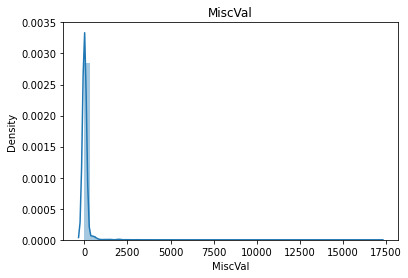

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


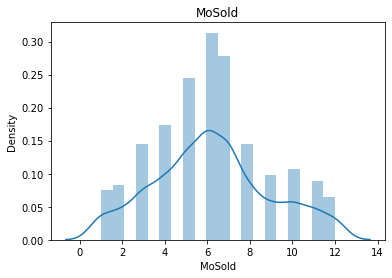

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


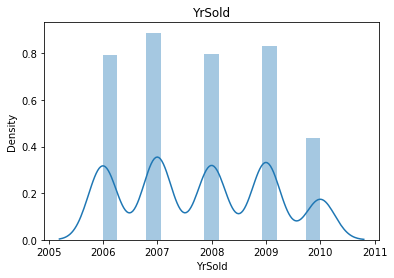

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


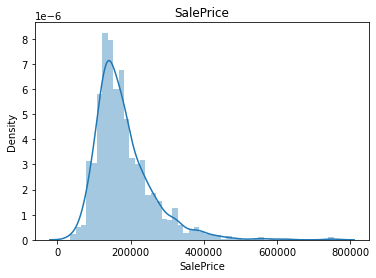

In [13]:
# 用 KDE(Kernel Density Estimation) 來細看個別特徵的詳細分布情形，作為後續特徵工程的參考
for i in list(num_data.columns):
    sns.distplot(num_data[i].dropna()).set_title(i)
    plt.show()

# 有大量 0 的欄位，可以考慮重編碼成類別欄位成有或無 (1 or 0)

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


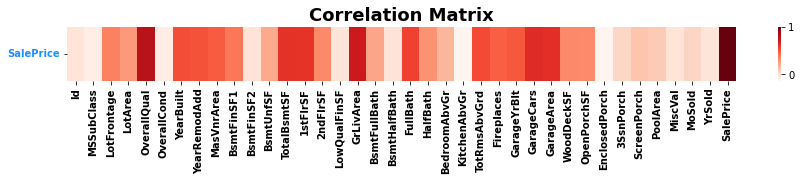

In [28]:
# 數值特徵跟預測變數 (SalePrice) 的相關係數矩陣，然後把相關性最高的幾個特徵列出來
num_train = train.select_dtypes(['int64', 'float64'])
num_corr = num_train.corr().drop('Id') # corr()，用來找變數之間的相關性
fig, ax = plt.subplots(figsize = (15, 1))
sns.heatmap(num_corr.sort_values(by=['SalePrice'], ascending=False).head(1), cmap='Reds')
plt.title("Correlation Matrix", weight='bold', fontsize=18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)

# 前10名
print(num_corr['SalePrice'].sort_values(ascending=False).iloc[1:11])

# 可以發現OverallQual(整體狀況評分)、GrLivArea(居住面積)相關性最高

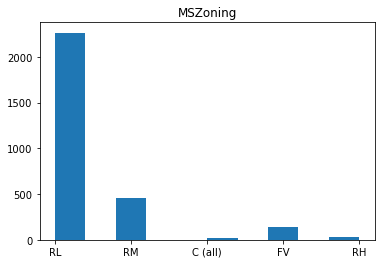

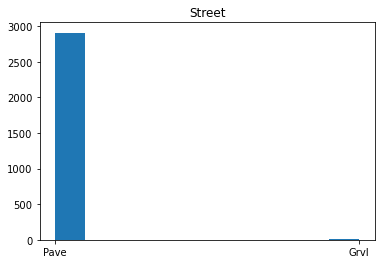

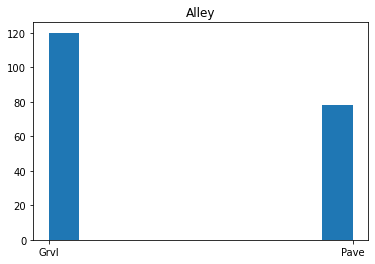

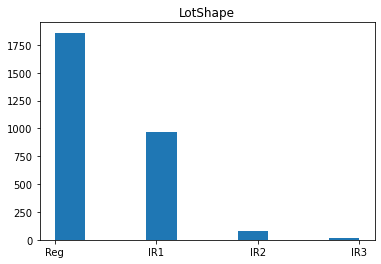

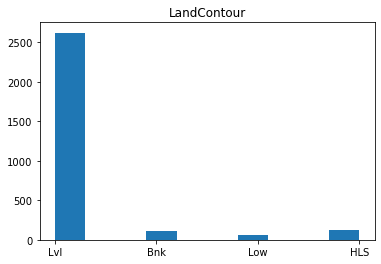

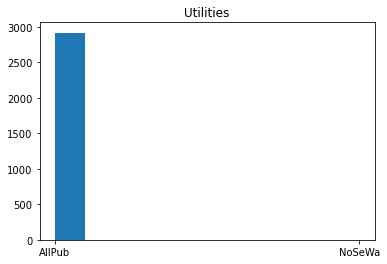

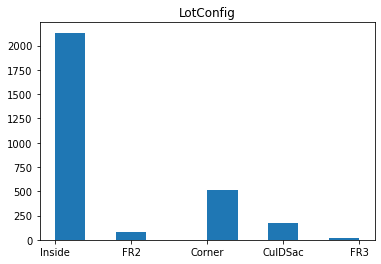

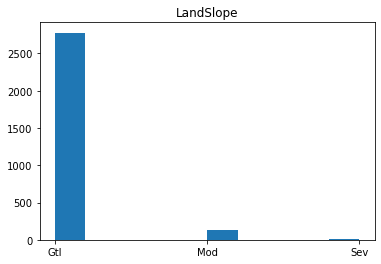

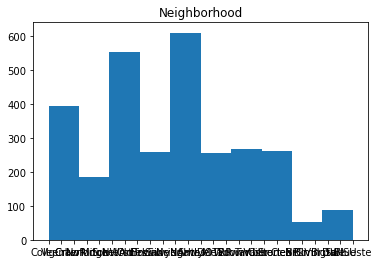

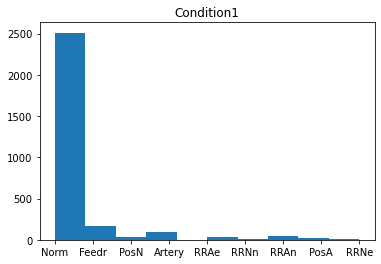

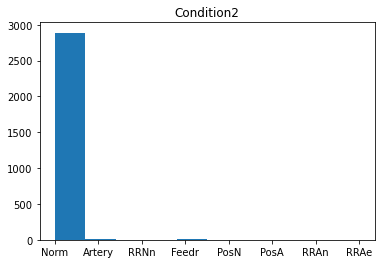

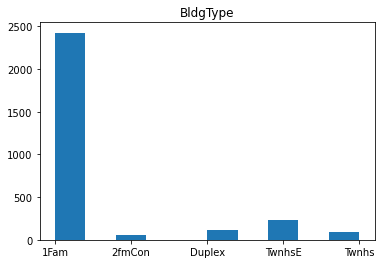

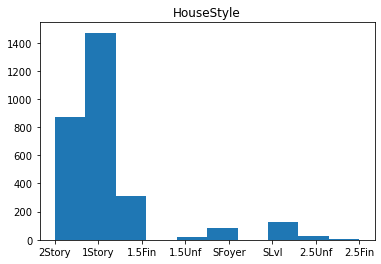

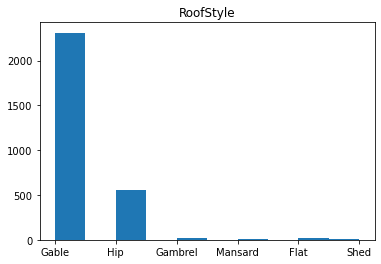

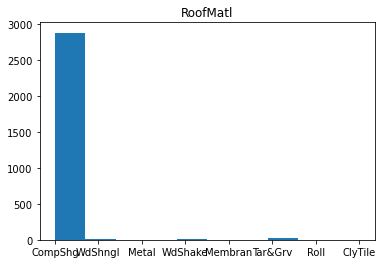

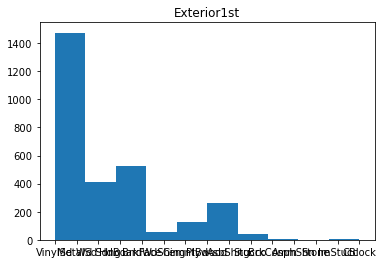

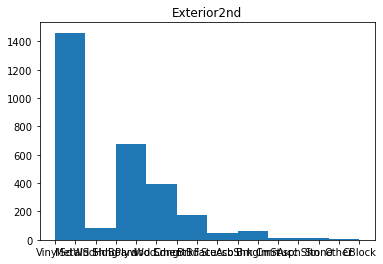

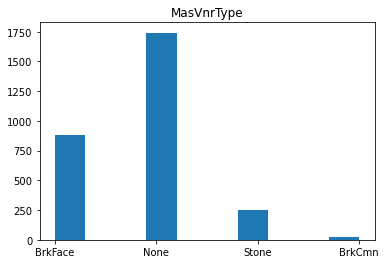

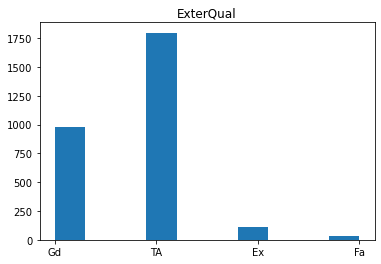

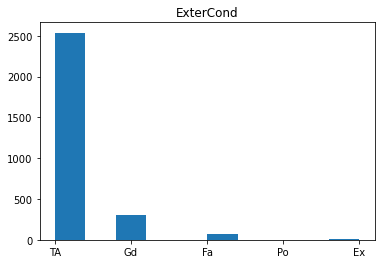

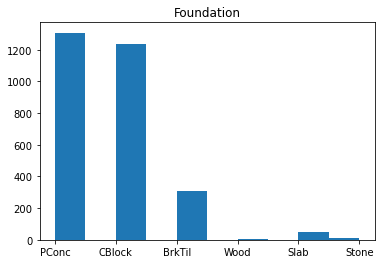

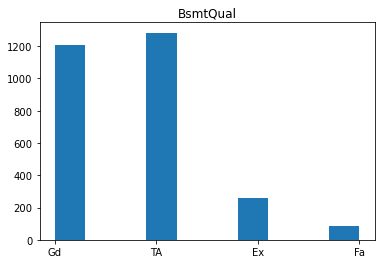

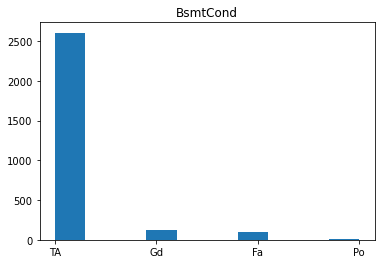

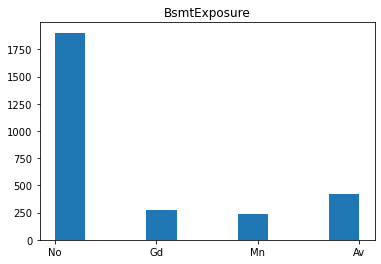

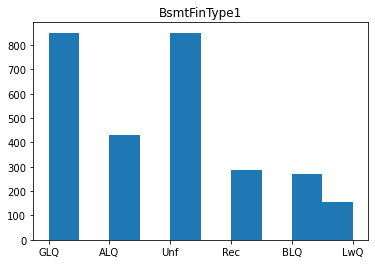

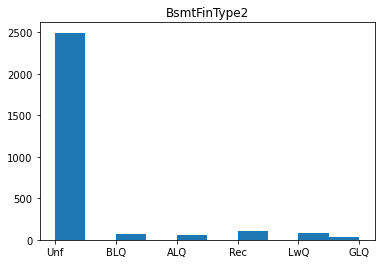

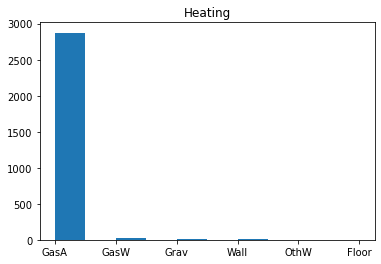

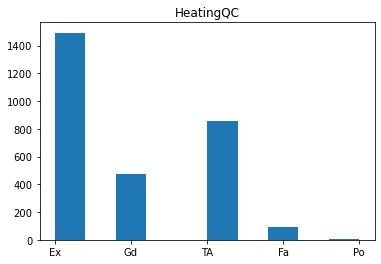

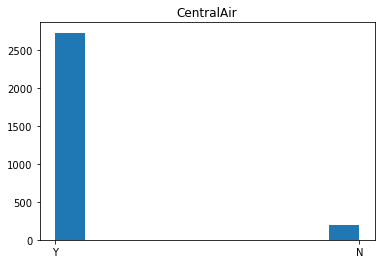

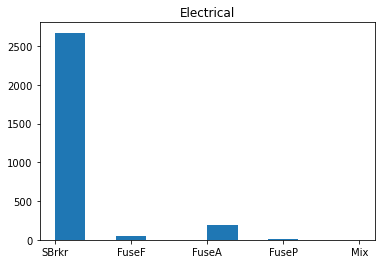

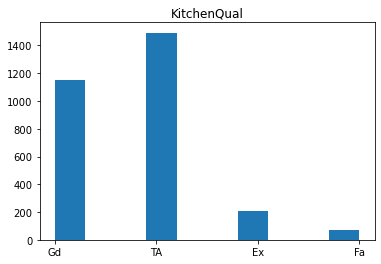

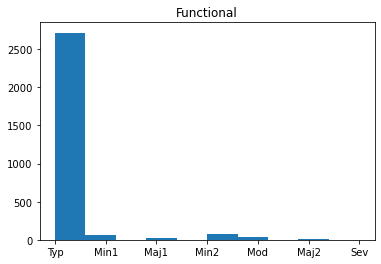

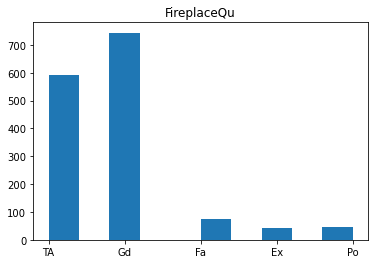

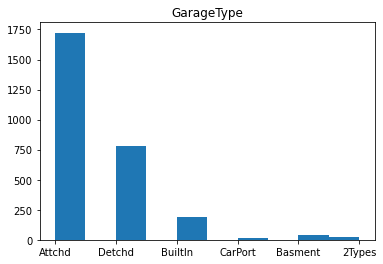

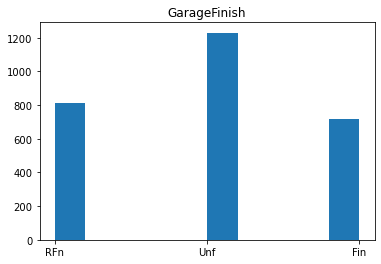

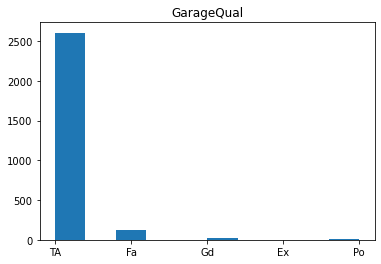

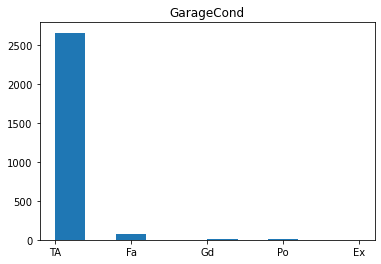

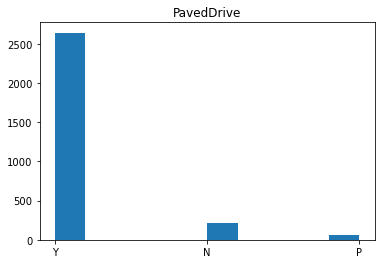

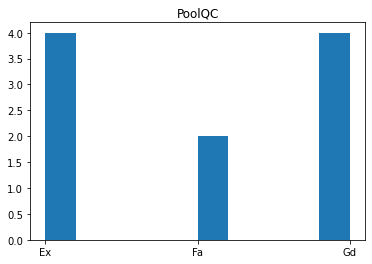

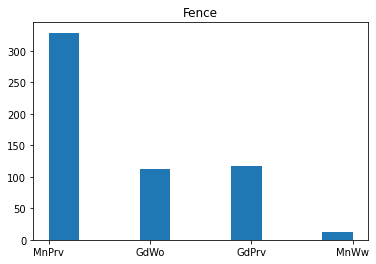

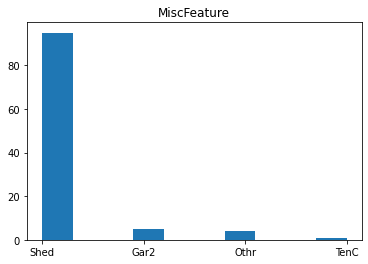

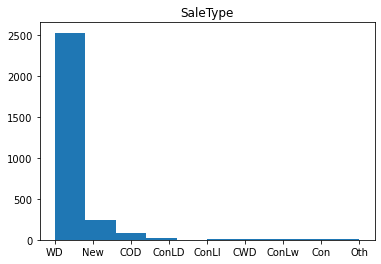

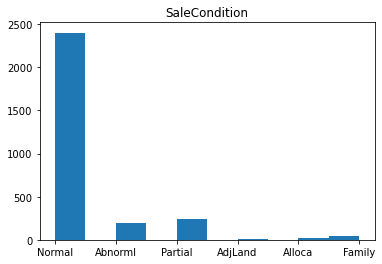

In [41]:
# 處理類別類型的資料
cat_data = data.select_dtypes(['object'])
for i in list(cat_data.columns):
    fig, ax = plt.subplots(1, 1)
    ax.hist(cat_data[i].dropna())
    ax.set_title(i, fontsize=12, color='Black')
    plt.show()

# 可以觀察到少部分的特徵分布情形過分集中單一類別，可以考慮排除這些欄位

## 遺漏值處理
計算各特徵的遺漏率，排序後繪圖，找出遺漏值特別誇張的特徵

<AxesSubplot:xlabel='0', ylabel='index'>

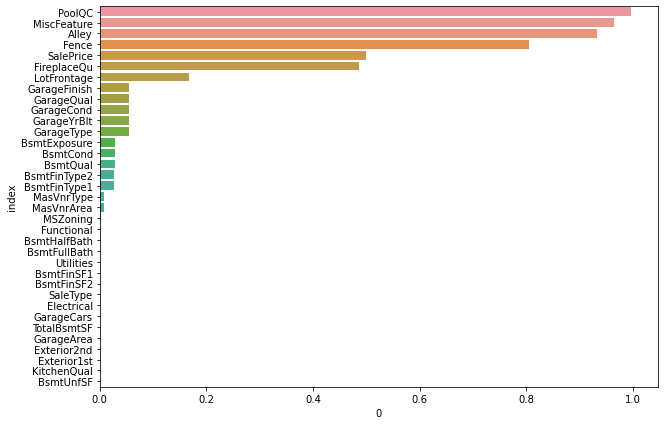

In [53]:
# 遺漏值檢查
# 計算各類別的遺漏率
missing_columns = data.isnull().mean().sort_values(ascending=False)
# 去除遺漏率 =0 的部分，並且給予 index 值
missing_columns = missing_columns[missing_columns!=0].to_frame().reset_index()

# 遺漏率繪圖
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x=0, y='index', data=missing_columns)

# 可以觀察到有些特徵遺漏率超過 80%，甚至還接近 100%

In [54]:
# 依不同的欄位特性，分三種方式來處理遺漏值

# 1.移除遺漏值太多及分布太集中的特徵
data = data.drop(columns=['Heating', 'RoofMatl', 'Condition2', 'Utilities', 'Street', 'PoolQC', 
                          'MiscFeature', 'Alley', 'Fence'], axis=1)

# 2.類別 (category) 特徵補 none、數值特徵補 0，這類的遺漏原因大多是那間房子沒有該設備
missing_cat = ['FireplaceQu', 'GarageCond', 'GarageType', 'GarageFinish' ,'GarageQual', 'BsmtExposure', 
               'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrType', 'Electrical', 
               'MSZoning', 'Functional', 'Exterior1st', 'KitchenQual', 'Exterior2nd', 'SaleType']
missing_num = ['LotFrontage', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF', 'GarageArea', 
              'BsmtUnfSF', 'BsmtFinSF2', 'GarageCars', 'BsmtFinSF1']

for i in missing_cat:
    data[i] = data[i].fillna('none')
for i in missing_num:
    data[i] = data[i].fillna(0)

# 3.車庫建造年(GarageYrBlt)，建造年的部分，補中位數或平均值較適當
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(data['GarageYrBlt'].median())

## 極端值處理
在這次資料集中不到3000筆資料的小資料集來說，極端值對模型的影響極大，必須處理

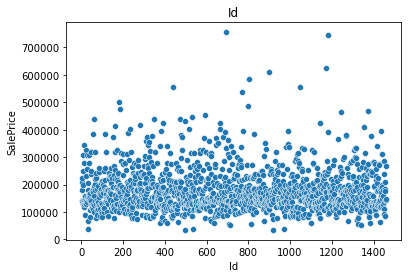

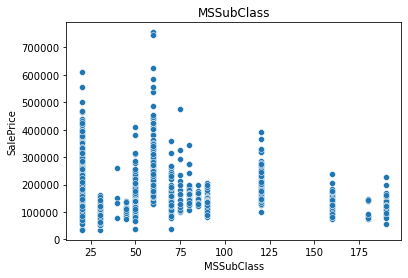

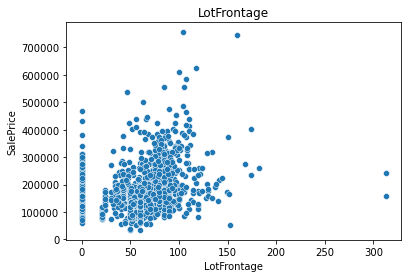

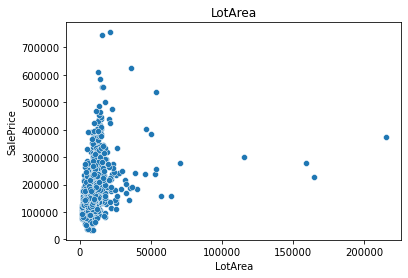

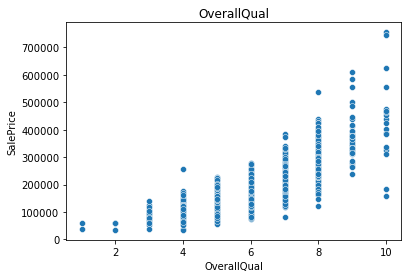

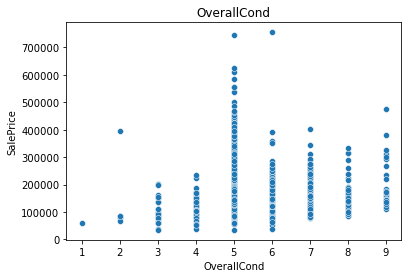

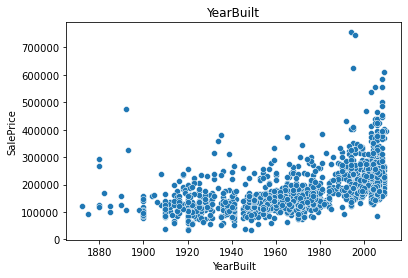

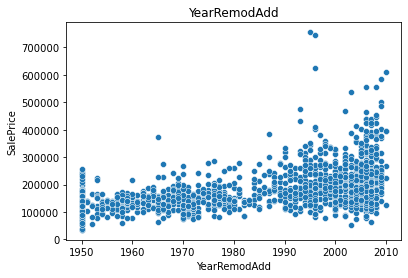

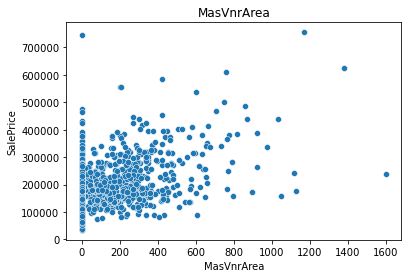

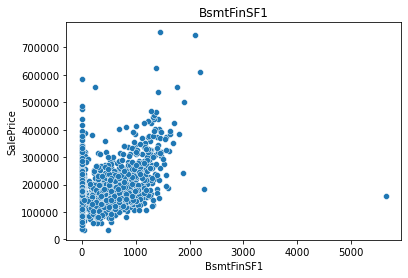

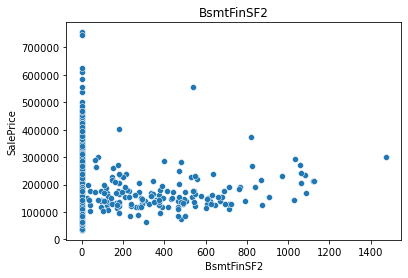

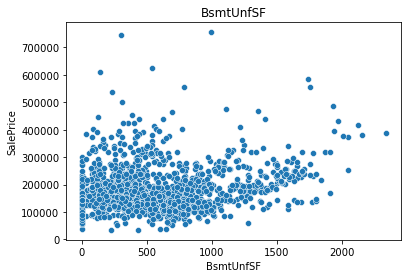

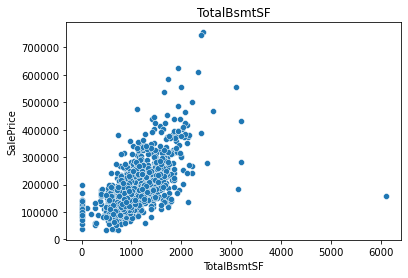

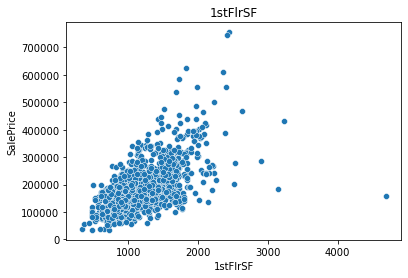

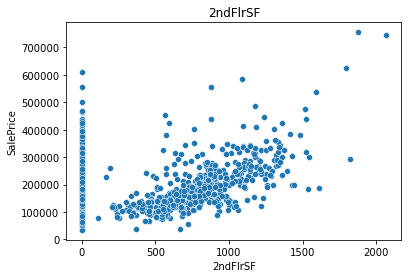

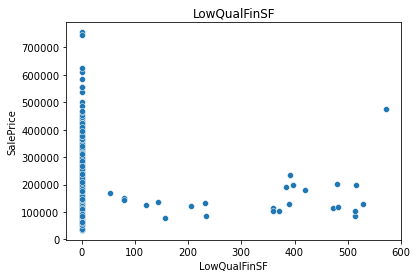

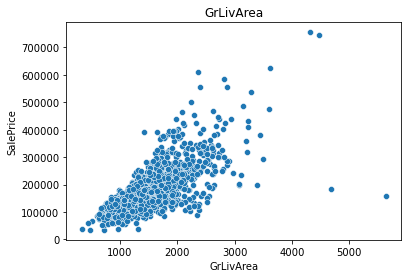

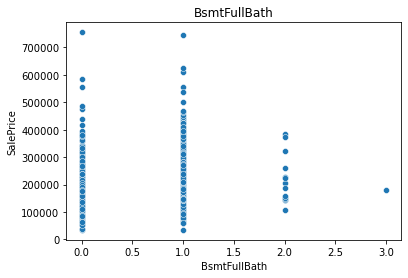

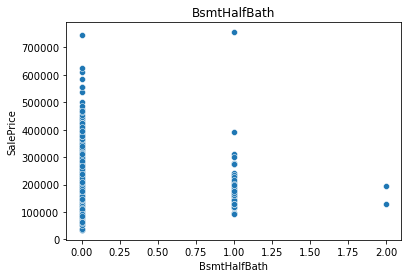

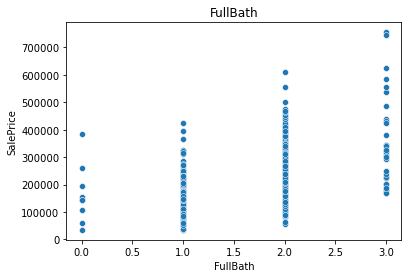

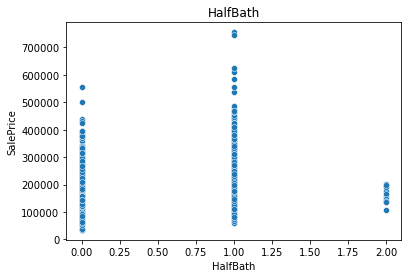

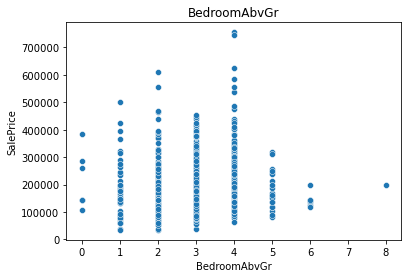

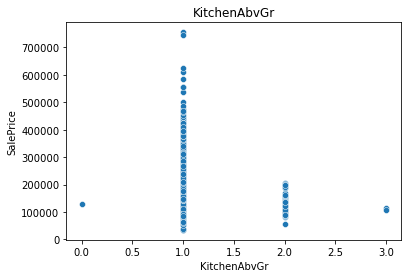

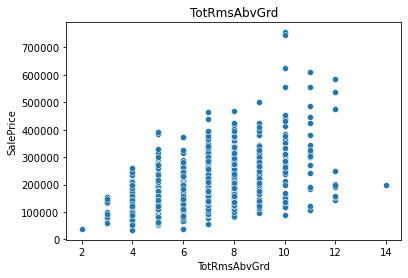

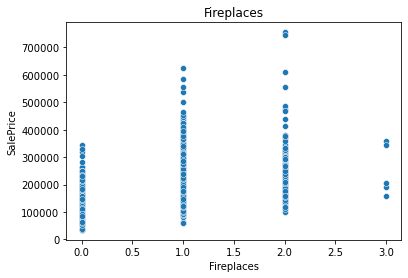

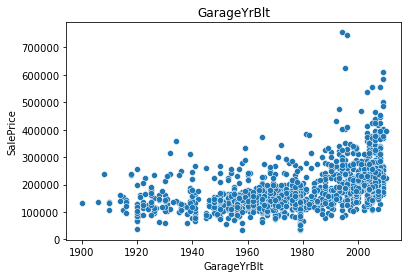

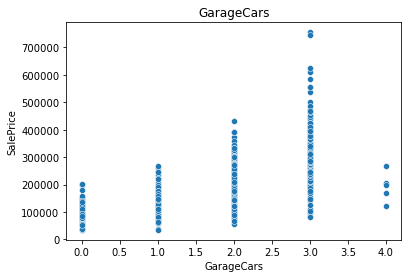

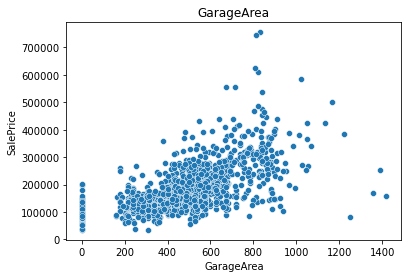

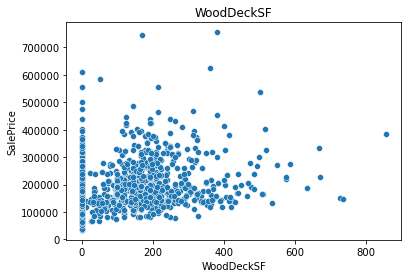

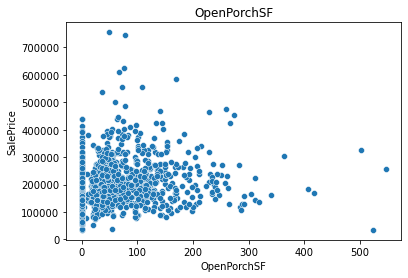

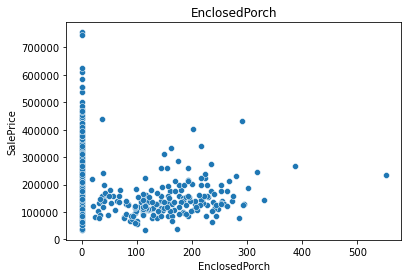

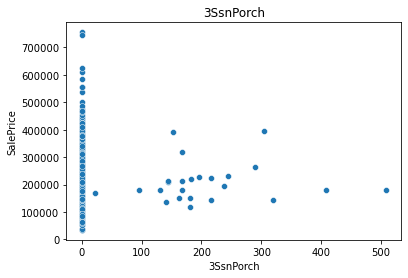

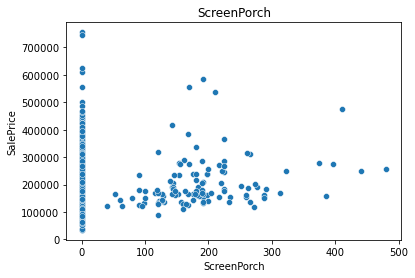

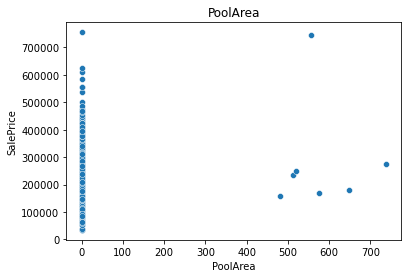

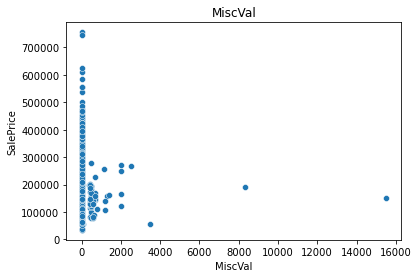

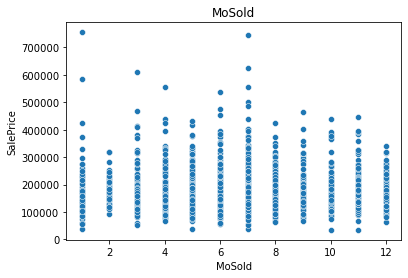

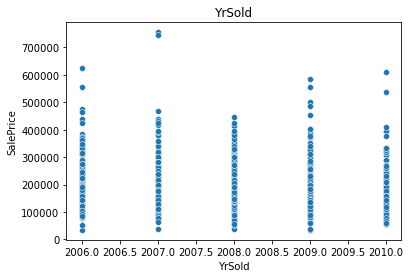

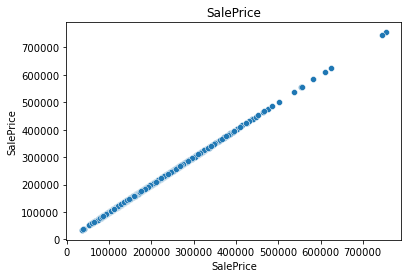

In [58]:
# 先前已經透過 KDE 大概了解數值欄位的分布情形，確實有極端值存在
# 透過畫出各數值特徵與房價的二維分布散布圖，進一步定位可能的極端樣本

data_remove_outlier = data[:1460] # 前 1460 筆資料，也就是 train 的部分
for c in num_train:
    sns.scatterplot(x=c, y="SalePrice", data=data_remove_outlier).set_title(c, fontsize=12, color='Black')
    plt.show()

In [70]:
# 將極端樣本移除
outlier_columns = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF',
                   'GrLivArea', 'BedroomAbvGr', 'TotRmsAbvGrd', 'MiscVal']
outlier_threshold = [300, 1400, 5000, 6000, 4000, 4500, 8, 14, 8000] # 設臨界值

# zip(c, n)，會將 c, n 一對一的方式配對
for c, n in zip(outlier_columns, outlier_threshold):
    data_remove_outlier = data_remove_outlier[data_remove_outlier[c]<n]

# 將移除完極端值的 train 資料與 test 資料合併
data = pd.concat((data_remove_outlier, data[1460:]), sort=False).reset_index(drop=True)

## 特徵工程

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


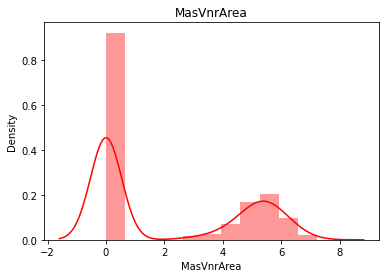

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


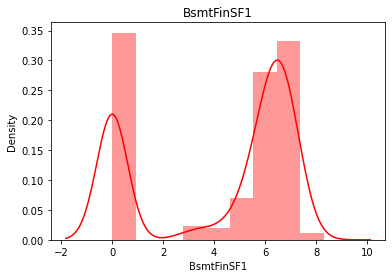

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


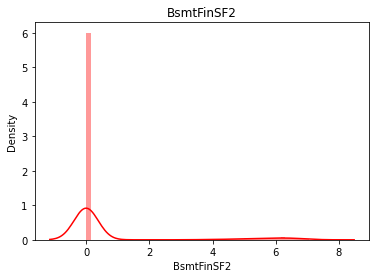

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


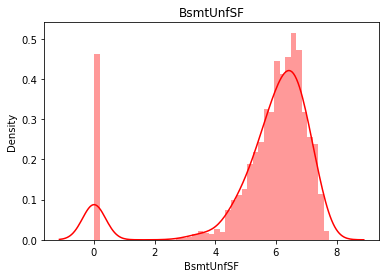

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


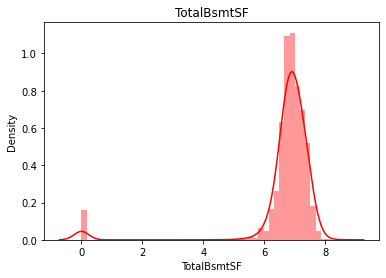

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


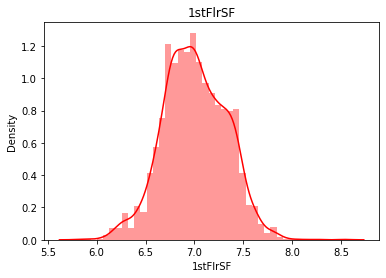

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


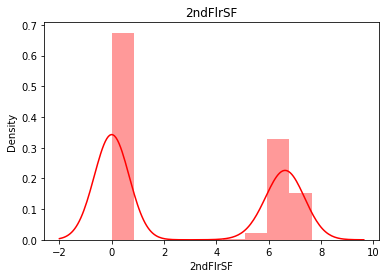

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


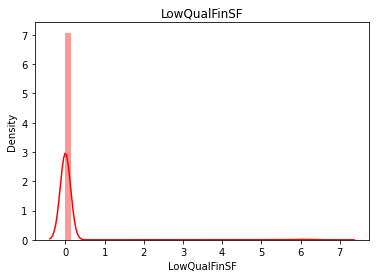

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


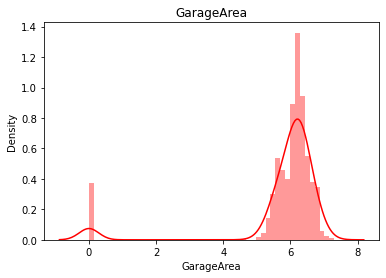

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


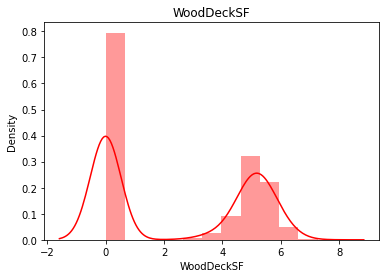

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


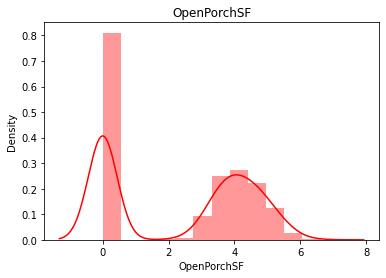

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


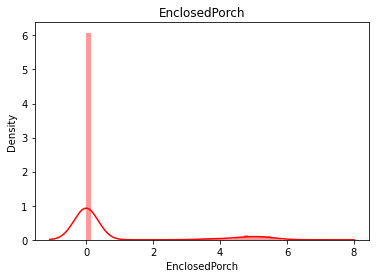

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


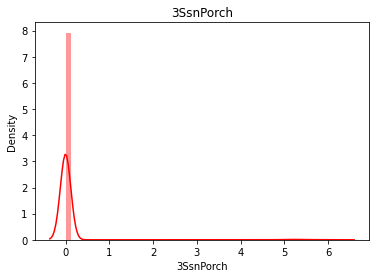

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


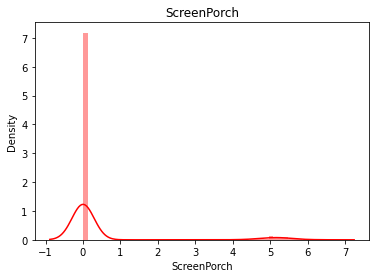

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


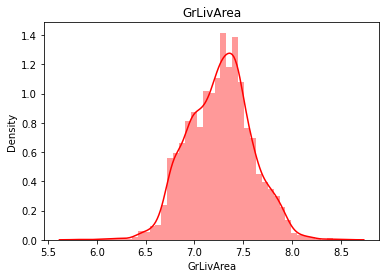

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


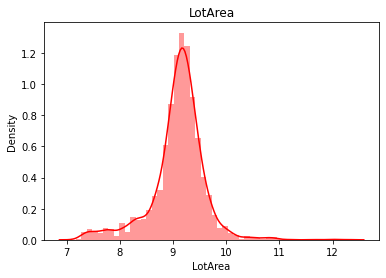

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


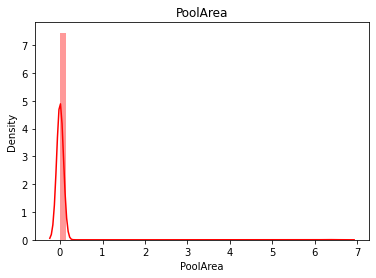

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


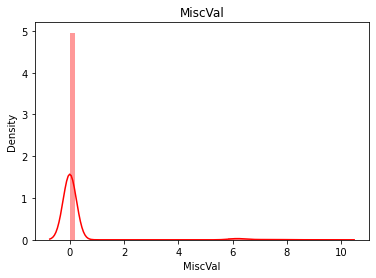

In [71]:
# 對數轉換：面積相關的特徵，大多為左偏分布，全部對數化處理，使其趨近常態分佈
for i in list(['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
               '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'WoodDeckSF', 
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'GrLivArea', 
               'LotArea', 'PoolArea', 'MiscVal']):
    data[i] = (np.log1p(data[i].dropna()))
    
for i in list(['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
               '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'WoodDeckSF', 
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'GrLivArea', 
               'LotArea', 'PoolArea', 'MiscVal']):
    sns.distplot(data[i].dropna(), color='red').set_title(i)
    plt.show()

In [75]:
# 類別特徵轉順序特徵
for i in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
          'FireplaceQu', 'GarageQual', 'GarageCond']:
    data[i] = data[i].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'none'], [5, 4, 3, 2, 1, 0]).astype(int)
    
for i in ['BsmtExposure']:
    data[i] = data[i].replace(['Gd', 'Av', 'Mn', 'No', 'none'], [4, 3, 2, 1, 0]).astype(int)
    
for i in ['BsmtFinType1', 'BsmtFinType2']:
    data[i] = data[i].replace(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'none'], [6, 5, 4, 3, 2, 1, 0]).astype(int)

In [77]:
# 年份特徵轉換
# 銷售時屋齡
data['House_year'] = data['YrSold'] - data['YearBuilt']

# 銷售時屋齡 (整修)
data['Remod_year'] = data['YrSold'] - data['YearRemodAdd']

# 幾年前建造車庫
data['Garage_bulit'] = data['YrSold'] - data['GarageYrBlt']

In [78]:
# 部分數值欄位離散化
# 年月份、MSSubClass轉類別
for i in ['YrSold', 'MSSubClass', 'MoSold']:
    data[i] = data[i].astype(str)

In [97]:
# 將類別變數做 One-Hot Encoding，以及區分訓練集、驗證集、測試集(提交用)

# 用 get_dummies()做 One-Hot Encoding
data_final = pd.get_dummies(data)
data_final = data_final.drop(['Id'], axis=1).reset_index(drop=True)

x = data_final[:1453].drop('SalePrice', axis=1)
y = np.array(np.log1p(data_remove_outlier['SalePrice'])) # data_remove_outlier 也就是 train 的部分
Test = data_final[1453:].drop('SalePrice', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=321)

##  單一模型建模

In [80]:
# Regularized Regression家族
# 1.Ridge Regression

from sklearn.linear_model import RidgeCV
# set cross-validation alpha
alpha=[0.0001,0.001,0.01,0.1,1,10,100]
# find the best alpha and build model
Ridge = RidgeCV(cv=5, alphas=alpha,normalize=True)
Ridge_fit=Ridge.fit(x_train,y_train)
y_ridge_train=Ridge_fit.predict(x_train)
y_ridge_test=Ridge_fit.predict(x_test)
# validation( train data and validate data)
print('RMSE_train_Ridge = ' + str(math.sqrt(sklm.mean_squared_error(y_train, y_ridge_train))))
print('RMSE_test_Ridge = ' + str(math.sqrt(sklm.mean_squared_error(y_test, y_ridge_test))))

C:\Users\cody8\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\cody8\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\cody8\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\cody8\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

RMSE_train_Ridge = 0.0957396826157619
RMSE_test_Ridge = 0.11697502991346177


C:\Users\cody8\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\cody8\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

In [81]:
# 2.Lasso Regression

from sklearn.linear_model import LassoCV
# set cross-validation alpha
alpha=[0.0001,0.001,0.01,0.1,1,10,100]
# find the best alpha and build model
Lasso = LassoCV(cv=5, alphas=alpha,normalize=True)
Lasso_fit=Lasso.fit(x_train,y_train)
y_lasso_train=Lasso_fit.predict(x_train)
y_lasso_test=Lasso_fit.predict(x_test)
# validation( train data and validate data)
print('RMSE_train_Lasso = ' + str(math.sqrt(sklm.mean_squared_error(y_train, y_lasso_train))))
print('RMSE_test_Lasso = ' + str(math.sqrt(sklm.mean_squared_error(y_test, y_lasso_test))))

RMSE_train_Lasso = 0.10153609532527076
RMSE_test_Lasso = 0.1105483886733663


C:\Users\cody8\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [82]:
# 3.ElasticNet Regression

from sklearn.linear_model import ElasticNetCV
# set cross-validation alpha and l1ratio
alpha=[0.0001,0.001,0.01,0.1,1,10,100]
l1ratio = [0.1, 0.5, 0.9, 0.95, 0.99, 1]
# find the best alpha/l1ratio and build model
elastic_cv = ElasticNetCV(cv=5, max_iter=1e7, alphas=alpha,  l1_ratio=l1ratio,normalize=True)
elastic_fit = elastic_cv.fit(x_train, y_train)
y_el_train=elastic_fit.predict(x_train)
y_el_test=elastic_fit.predict(x_test)
# validation( train data and validate data)
print('RMSE_train_ElasticNet = ' + str(math.sqrt(sklm.mean_squared_error(y_train, y_el_train))))
print('RMSE_test_ElasticNet = ' + str(math.sqrt(sklm.mean_squared_error(y_test, y_el_test))))

RMSE_train_ElasticNet = 0.10153609532527076
RMSE_test_ElasticNet = 0.1105483886733663


C:\Users\cody8\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(


In [83]:
# 3 個模型測試集與驗證集的 RMSE 之間差距並不大，顯示 over fitting 的情況不明顯，模型穩定度還算 ok

In [85]:
# 4.LightGBM

from lightgbm import LGBMRegressor
estimator=LGBMRegressor()
parameter_grid={
        'max_depth':range(2,5,1),
        'learning_rate':np.linspace(0.001,1,20),
        'feature_fraction':np.linspace(0.5,0.99,20),
        'bagging_fraction':np.linspace(0.1,0.99,20),
        'bagging_frequency':range(5,10,1),
        'num_leaves':range(100,200,5),
        'min_data_in_leaf':range(50,200,10),
        'n_estimators':range(100,5000,100)}
grid = RandomizedSearchCV(estimator,parameter_grid,cv = 3,scoring = 'neg_root_mean_squared_error',n_iter=500,n_jobs = -1)
grid.fit(x_train, y_train)
# print best parameter combination
print (grid.best_params_)

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] feature_fraction is set=0.5257894736842105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5257894736842105
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.2873684210526316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2873684210526316
{'num_leaves': 140, 'n_estimators': 300, 'min_data_in_leaf': 50, 'max_depth': 2, 'learning_rate': 0.1061578947368421, 'feature_fraction': 0.5257894736842105, 'bagging_frequency': 6, 'bagging_fraction': 0.2873684210526316}


In [94]:
# 5.XGboost

from xgboost.sklearn import XGBRegressor
estimator=XGBRegressor()
parameter_grid={
        'max_depth':range(2,5,1),
        'learning_rate':np.linspace(0.001,1,20),
        'colsample_bytree':np.linspace(0.1,0.99,20),
        'num_leaves':range(100,200,5),
        'n_estimators':range(100,5000,100)}
grid = RandomizedSearchCV(estimator,parameter_grid,cv = 5,scoring = 'neg_root_mean_squared_error',n_iter=500,n_jobs = -1)
grid.fit(x_train, y_train)
# print best parameter combination
print (grid.best_params_)

KeyboardInterrupt: 

In [87]:
xgb= XGBRegressor(base_score=0.5, 
                  booster='gbtree', 
                  colsample_bylevel=1,
                  colsample_bynode=1, 
                  colsample_bytree=0.7, 
                  gamma=0,
                  importance_type='gain', 
                  learning_rate=0.01,
                  max_delta_step=0,
                  max_depth=3, 
                  min_child_weight=0, 
                  missing=None, 
                  n_estimators=1000,
                  n_jobs=1, 
                  nthread=None, 
                  objective='reg:squarederror', 
                  random_state=0,
                  reg_alpha=1, 
                  reg_lambda=1, 
                  scale_pos_weight=1, 
                  seed=None,
                  silent=None, 
                  subsample=1, 
                  verbosity=1)
xgb_fit = xgb.fit(x_train, y_train)
y_xgb_train=xgb_fit.predict(x_train)
y_xgb_test=xgb_fit.predict(x_test)
print('RMSE_train_LGBM = ' + str(math.sqrt(sklm.mean_squared_error(y_train, y_lgbm_train))))
print('RMSE_test_LGBM = ' + str(math.sqrt(sklm.mean_squared_error(y_test, y_lgbm_test))))

C:\Users\cody8\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBoostError: [19:34:43] c:\ci\xgboost-split_1638290375667\work\src\c_api\c_api_utils.h:161: Invalid missing value: null

In [88]:
from sklearn.ensemble import VotingRegressor
# Build Model
vote_mod = VotingRegressor([('Ridge', Ridge_fit), ('Lasso', Lasso_fit), ('Elastic', elastic_fit), ('lgbm', lgbm_fit),('xgb',xgb_fit)])vote= vote_mod.fit(x_train, y_train.ravel())
# predict train/test y
vote_pred_train=vote.predict(x_train)
vote_pred_test=vote.predict(x_test)
# validation( train data and validate data)
print('RMSE_train_Voting = ' + str(math.sqrt(sklm.mean_squared_error(y_train, vote_pred_train))))
print('RMSE_test_Voting = ' + str(math.sqrt(sklm.mean_squared_error(y_test, vote_pred_test))))

SyntaxError: invalid syntax (3000103157.py, line 3)

In [91]:
import mlxtend
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Build Model
gbdt=GradientBoostingRegressor(learning_rate=0.05,
                               max_leaf_nodes=3,
                              n_estimators=100)
stregr = StackingRegressor(regressors=[Ridge_fit, Lasso_fit, elastic_fit, lgbm_fit,xgb_fit], 
                           meta_regressor=gbdt, 
                           use_features_in_secondary=True)
stack_mod=stregr.fit(x_train, y_train.ravel())
# predict train/test y
stacking_pred_train=stack_mod.predict(x_train)
stacking_pred_test=stack_mod.predict(x_test)
# validation( train data and validate data)
print('RMSE_train_Stacking = ' + str(math.sqrt(sklm.mean_squared_error(y_train, stacking_pred_train))))
print('RMSE_test_Stacking = ' + str(math.sqrt(sklm.mean_squared_error(y_test, stacking_pred_test))))

NameError: name 'lgbm_fit' is not defined

In [92]:
# set weight list
weight=list(np.linspace(0.1,1,91))
# create outcome dataframe 
train_mse=[]
test_mse=[]
for i in weight:
    blending_pred_train=(i*vote_pred_train)+((1-i)*stacking_pred_train)
    blending_pred_test=(i*vote_pred_test)+((1-i)*stacking_pred_test)
    train_mse.append(math.sqrt(sklm.mean_squared_error(y_train, blending_pred_train)))
    test_mse.append(math.sqrt(sklm.mean_squared_error(y_test, blending_pred_test)))
blending_output=pd.DataFrame({'weight':weight,
                              'train_mse':train_mse,
                              'test_mse':test_mse})
# print top 10 weight value
print (blending_output.sort_values(by=['test_mse'],ascending=True).head(10))

NameError: name 'vote_pred_train' is not defined

In [93]:
# predict and blending
final_pred_voting=vote.predict(Test)
final_pred_stacking=stack_mod.predict(Test)
final_pred_blending=0.94*final_pred_voting+0.06*final_pred_stacking
# reverse log y
final_pred_blending=np.expm1(final_pred_blending)
a=list(range(1461,2920,1))
submit=pd.DataFrame({'Id':list(range(1461,2920,1)),
                     'SalePrice':final_pred_blending})
    
# save as csv     
submit.to_csv('submit.csv',index=False)

NameError: name 'vote' is not defined